# Imports

In [1]:
import json
from copy import deepcopy
from os import makedirs
from pathlib import Path
from typing import Optional

import graphviz
import numpy as np
import pydot
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_covtype, load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras, nn
from tensorflow.keras import callbacks, layers
from tensorflow.keras import utils as kutils
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.saving import load_model

# Methods

## Data loaders

In [2]:
def _common_sklearn_loader(data: dict) -> tuple[np.ndarray, np.ndarray]:
    return data["data"], kutils.to_categorical(data["target"])


def get_iris(**tts_kwargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = _common_sklearn_loader(load_iris())
    return train_test_split(X, y, **tts_kwargs)


def get_covtype(**tts_kwargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = _common_sklearn_loader(fetch_covtype())
    return train_test_split(X, y, **tts_kwargs)

## Model makers

In [52]:
MODEL_DIR = "models"


def _model_formats(name: str) -> Path:
    return Path(MODEL_DIR) / f"{name}.keras", Path(MODEL_DIR) / f"{name}_history.json"


def model_save(name: str, model: keras.Model, history: dict):
    makedirs(MODEL_DIR, exist_ok=True)
    model_path, history_path = _model_formats(name)
    model.save(model_path)
    with history_path.open("w") as h:
        json.dump(history, h)


def model_load(name: str) -> tuple[Optional[keras.Model], Optional[dict]]:
    def __read_history(history_path: Path) -> dict:
        with history_path.open() as h:
            return json.load(h)

    model_path, history_path = _model_formats(name)
    return None if not model_path.is_file() else load_model(
        model_path
    ), None if not history_path.is_file() else __read_history(history_path)


def _make_dense_end(
    layer_sizes: list[int], base_layer: layers.Layer = None
) -> layers.Layer:
    for size in layer_sizes[:-1]:
        base_layer = layers.Dense(size, activation=nn.relu)(base_layer)
    return layers.Dense(layer_sizes[-1], activation=nn.softmax)(base_layer)


def make_classic_dense(layer_sizes: list[int]) -> keras.Model:
    input = keras.Input(shape=(layer_sizes[0],))
    output = _make_dense_end(layer_sizes[1:], base_layer=input)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


def fit_multiple_dense(
    layer_sizes_list: list[list[int]],
    xtr,
    ytr,
    group_name: Optional[str] = None,
    FORCE_TRAIN: bool = False,
    **fit_kwargs,
):
    models = []
    for sizes in layer_sizes_list:
        name = f"{group_name if group_name is not None else 'dense'}_{'_'.join([str(size) for size in sizes])}"
        model, history = None, None
        if not FORCE_TRAIN:
            model, history = model_load(name)
        if model is None:
            model = make_classic_dense(sizes)
        if history is None:
            history = model.fit(xtr, ytr, **fit_kwargs).history
        model_save(name, model, history)
        models.append([name, model, history])
    return models


def define_stacked_model(
    models: list[keras.Model], master_layer_sizes: list[int]
) -> keras.Model:
    for i, layer in [
        [i, layer] for i, model in enumerate(models) for layer in model.layers
    ]:
        layer.trainable = False
        layer._name = "stack_" + str(i + 1) + "_" + "_".join(layer.name.split("_")[-2:])
    stacked_input = [model.input for model in models]
    stacked_output = [model.layers[-2].output for model in models]
    merge = Concatenate()(stacked_output) if len(stacked_output)>1 else stacked_output[0]
    output = _make_dense_end(master_layer_sizes, base_layer=merge)
    model = keras.Model(inputs=stacked_input, outputs=output)
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


def stacked_fit(
    model: keras.Model, xtr: np.ndarray, ytr: np.ndarray, **kwargs
) -> callbacks.History:
    xtr_mul = [xtr for _ in range(len(model.input))]
    if "validation_data" in kwargs:
        kwargs["validation_data"] = (
            [kwargs["validation_data"][0] for _ in range(len(model.input))],
            kwargs["validation_data"][1],
        )
    return model.fit(xtr_mul, ytr, **kwargs)


def stacked_evaluate(
    model: keras.Model, xts: np.ndarray, yts: np.ndarray, **kwargs
) -> tuple[float, float]:
    xts_mul = [xts for _ in range(len(model.input))]
    return model.evaluate(xts_mul, yts, **kwargs)

## Utils

In [4]:
def plot_history(history: dict, sup_txt: str = ""):
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(f"History {sup_txt}")

    ax_loss.plot(history["loss"], label="train")
    ax_loss.plot(history["val_loss"], label="test")
    ax_loss.grid()
    ax_loss.set_ylabel("Loss")
    ax_loss.set_xlabel("Epochs")
    ax_loss.legend()

    ax_acc.plot(np.array(history["accuracy"]) * 100, label="train")
    ax_acc.plot(np.array(history["val_accuracy"]) * 100, label="test")
    ax_acc.grid()
    ax_acc.set_ylabel("Accuracy [%]")
    ax_acc.set_xlabel("Epochs")
    ax_acc.legend()
    return fig, (ax_loss, ax_acc)

# Experiments

## Basic Iris POC

In [5]:
xtr, xts, ytr, yts = get_iris(train_size=0.7, shuffle=True)
iris_models_data = fit_multiple_dense(
    [[4, 8, 3], [4, 8, 8, 3], [4, 8, 16, 8, 3]],
    xtr,
    ytr,
    validation_data=(xts, yts),
    group_name="iris",
    FORCE_TRAIN=False,
    epochs=25,
    batch_size=10,
    verbose=0,
)
[
    [name, model.evaluate(xts, yts, batch_size=10, verbose=0)]
    for name, model, _ in iris_models_data
]

[['iris_4_8_3', [0.5701103806495667, 0.9555555582046509]],
 ['iris_4_8_8_3', [0.7757722735404968, 0.644444465637207]],
 ['iris_4_8_16_8_3', [0.8867671489715576, 0.4444444477558136]]]

[<Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>]

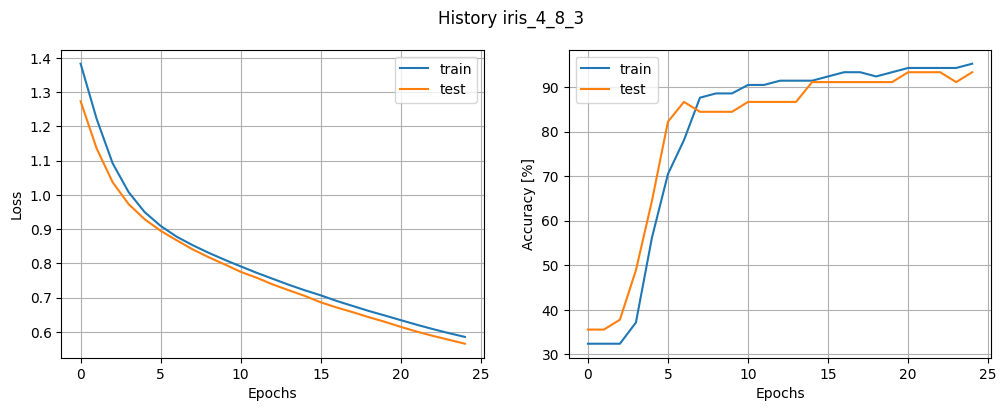

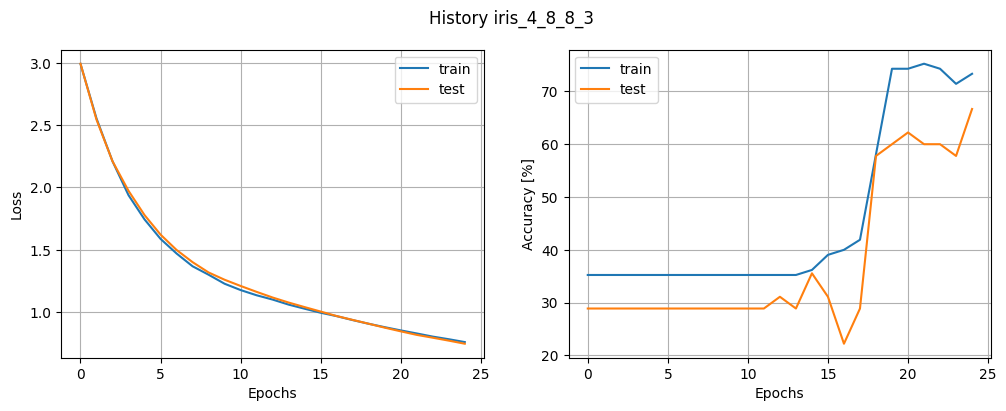

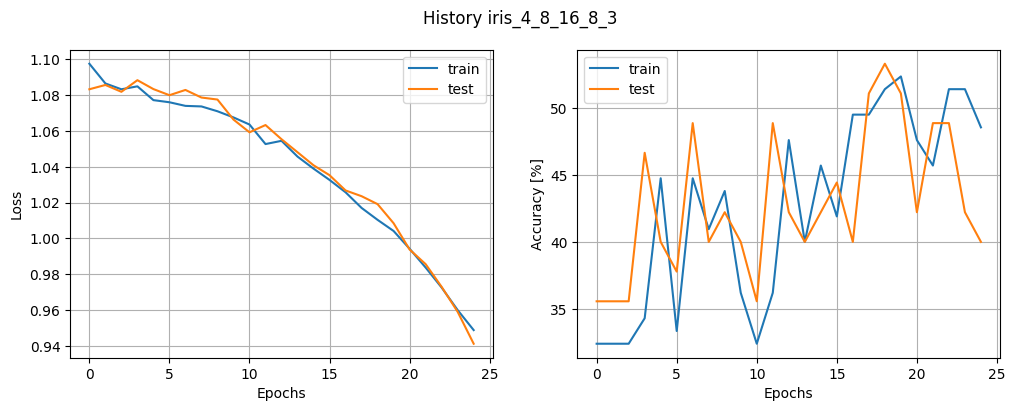

In [6]:
[plot_history(history, name)[0] for name, _, history in iris_models_data]

In [7]:
# iris_stacked_model = define_stacked_model(
#     [model_data[1] for model_data in iris_models_data], [10, 3]
# )
# iris_stacked_history = stacked_fit(
#     iris_stacked_model,
#     xtr,
#     ytr,
#     validation_data=(xts, yts),
#     epochs=25,
#     batch_size=10,
#     verbose=0,
# ).history
# model_save('stacked_iris', iris_stacked_model, iris_stacked_history)
iris_stacked_model, iris_stacked_history = model_load("stacked_iris")

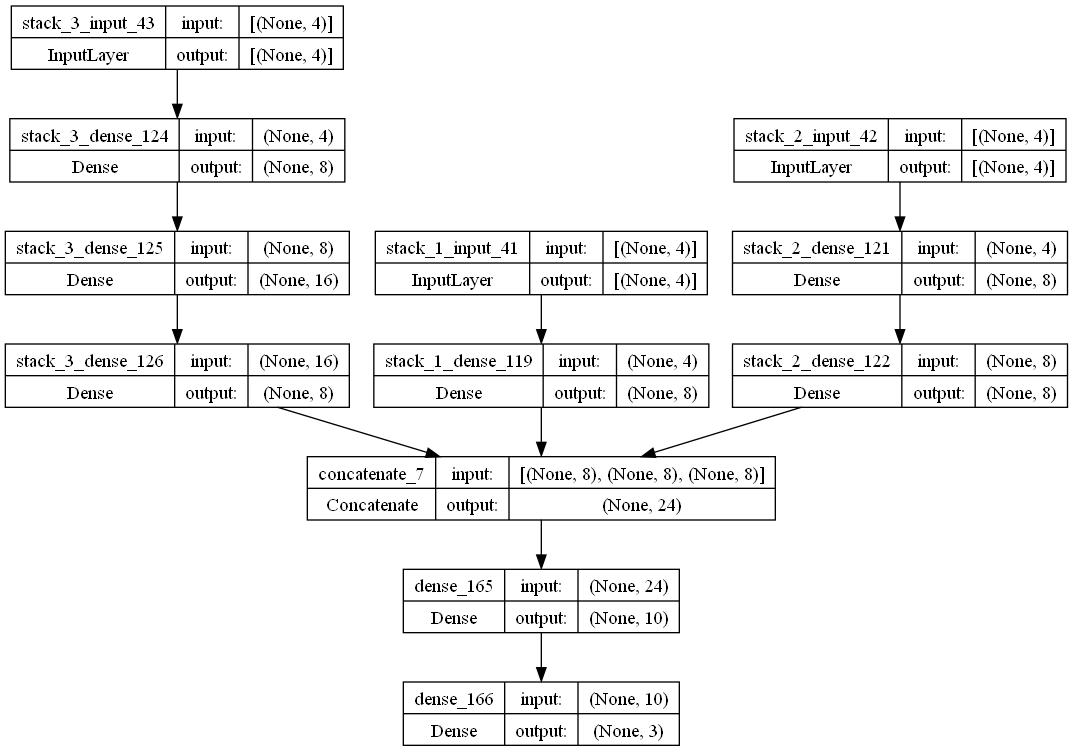

In [8]:
kutils.plot_model(iris_stacked_model, show_shapes=True)

(<Figure size 1200x400 with 2 Axes>,
 (<Axes: xlabel='Epochs', ylabel='Loss'>,
  <Axes: xlabel='Epochs', ylabel='Accuracy [%]'>))

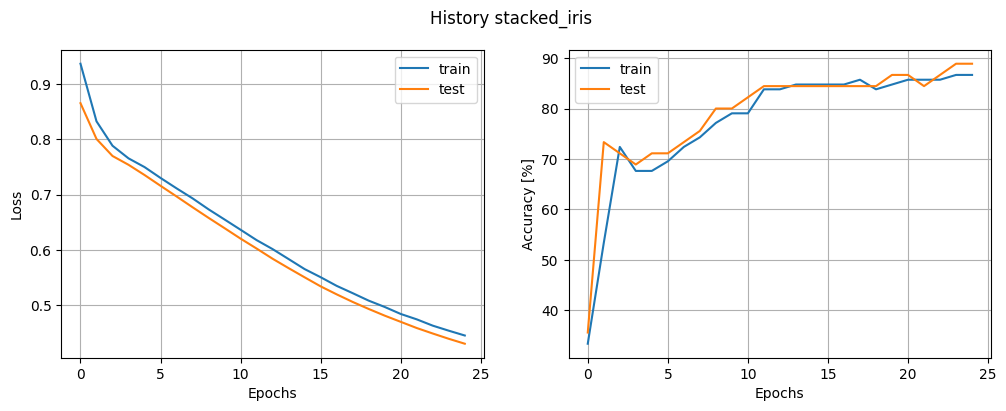

In [9]:
plot_history(iris_stacked_history, "stacked_iris")

In [10]:
stacked_evaluate(iris_stacked_model, xts, yts, batch_size=10, verbose=0)

[0.43937453627586365, 0.8888888955116272]

## Proper tests (covtype dataset)

### Repeat of POC with covtype

In [11]:
xtr, xts, ytr, yts = get_covtype(train_size=0.8, shuffle=True)
covtype_models_data = fit_multiple_dense(
    [[54, 27, 8], [54, 108, 54, 8], [54, 108, 216, 54, 8]],
    xtr,
    ytr,
    validation_data=(xts, yts),
    group_name="covtype",
    epochs=100,
    batch_size=256,
    verbose=0,
)
[
    [name, model.evaluate(xts, yts, batch_size=256, verbose=0)]
    for name, model, _ in covtype_models_data
]

[['covtype_54_27_8', [0.6081818342208862, 0.7438362240791321]],
 ['covtype_54_108_54_8', [0.38310930132865906, 0.8397373557090759]],
 ['covtype_54_108_216_54_8', [0.2368224412202835, 0.9041074514389038]]]

[<Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>]

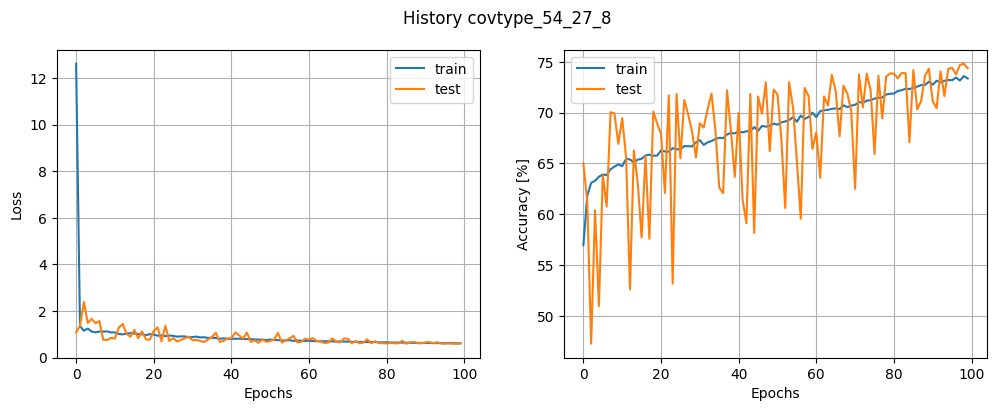

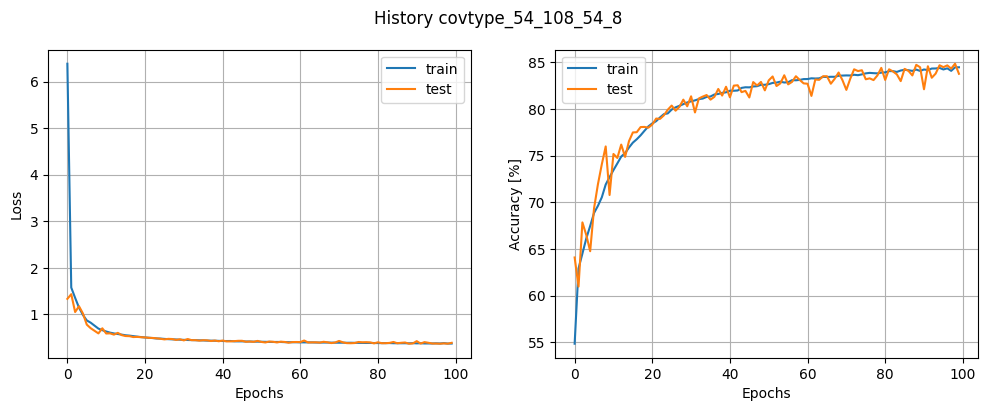

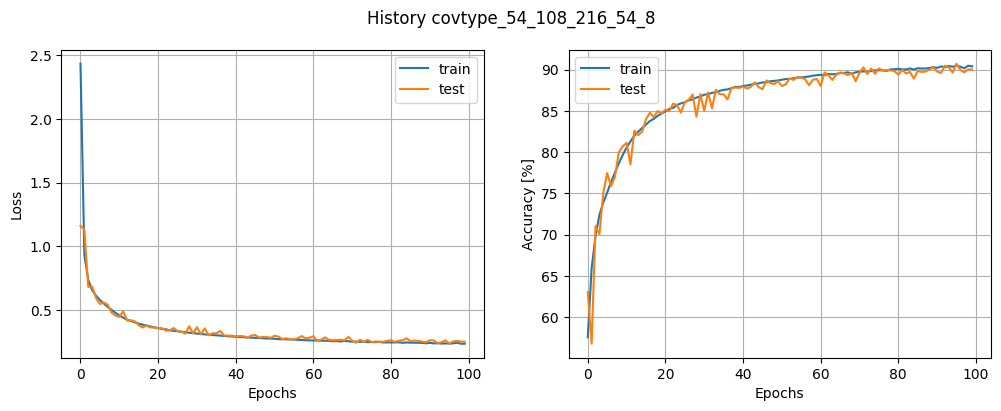

In [12]:
[plot_history(history, name)[0] for name, _, history in covtype_models_data]

In [13]:
# covtype_stacked_model = define_stacked_model(
#     [model_data[1] for model_data in covtype_models_data], [270, 135, 8]
# )
# covtype_stacked_history = stacked_fit(
#     covtype_stacked_model,
#     xtr,
#     ytr,
#     validation_data=(xts, yts),
#     epochs=100,
#     batch_size=256,
#     verbose=1,
# )
# model_save('stacked_covtype', covtype_stacked_model, covtype_stacked_history.history)
covtype_stacked_model, covtype_stacked_history = model_load("stacked_covtype")

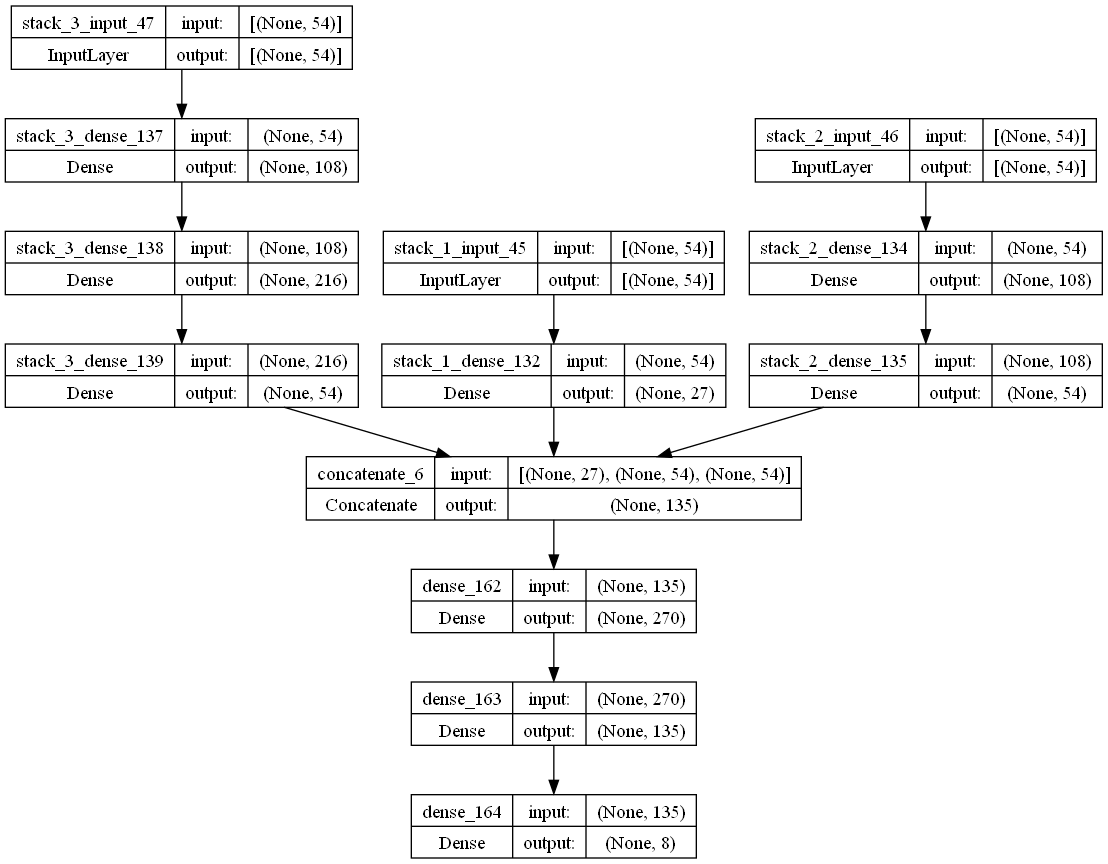

In [14]:
kutils.plot_model(covtype_stacked_model, show_shapes=True)

(<Figure size 1200x400 with 2 Axes>,
 (<Axes: xlabel='Epochs', ylabel='Loss'>,
  <Axes: xlabel='Epochs', ylabel='Accuracy [%]'>))

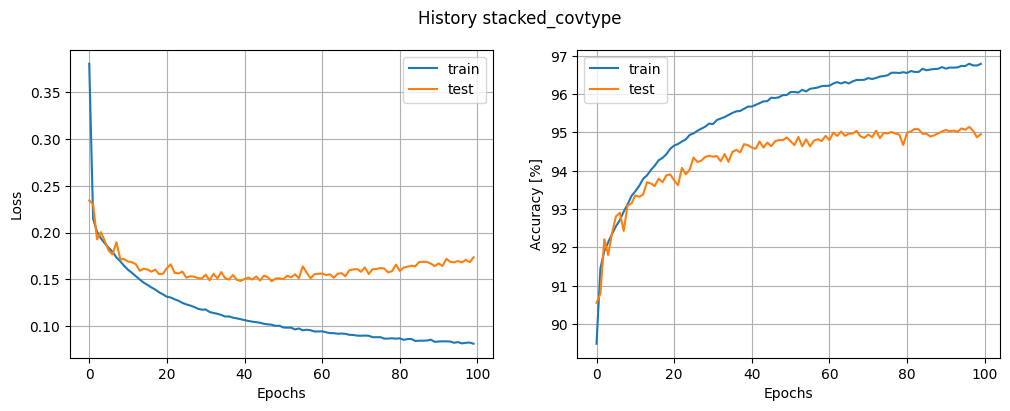

In [15]:
plot_history(covtype_stacked_history, "stacked_covtype")

In [16]:
stacked_evaluate(covtype_stacked_model, xts, yts, batch_size=256, verbose=0)

[0.09441064298152924, 0.9652074575424194]

### Several same shape subnets

In [25]:
same_models_data = []
for i in range(1, 6):
    print(f'Model: {i}')
    xtr, xts, ytr, yts = get_covtype(train_size=0.8, shuffle=True)
    same_models_data.extend(
        fit_multiple_dense(
            [[54, 108, 216, 54, 8]],
            xtr,
            ytr,
            validation_data=(xts, yts),
            group_name=f"covtype_v{i}",
            epochs=100,
            batch_size=256,
            verbose=0,
        )
    )
[
    [name, model.evaluate(xts, yts, batch_size=256, verbose=0)]
    for name, model, _ in same_models_data
]

Model: 1
Model: 2
Model: 3
Model: 4
Model: 5


[['covtype_v1_54_108_216_54_8', [0.2604024410247803, 0.8945379853248596]],
 ['covtype_v2_54_108_216_54_8', [0.24453026056289673, 0.9020507335662842]],
 ['covtype_v3_54_108_216_54_8', [0.25410640239715576, 0.8950715661048889]],
 ['covtype_v4_54_108_216_54_8', [0.25559261441230774, 0.8962677121162415]],
 ['covtype_v5_54_108_216_54_8', [0.226467102766037, 0.908659815788269]]]

[<Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>]

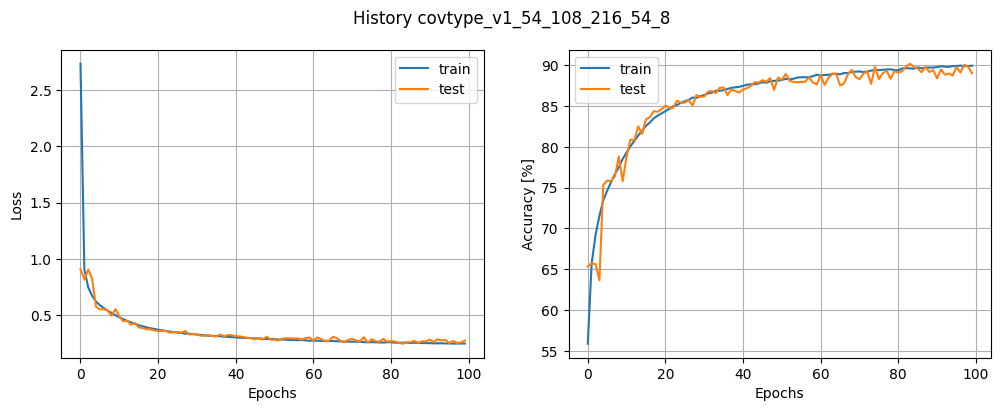

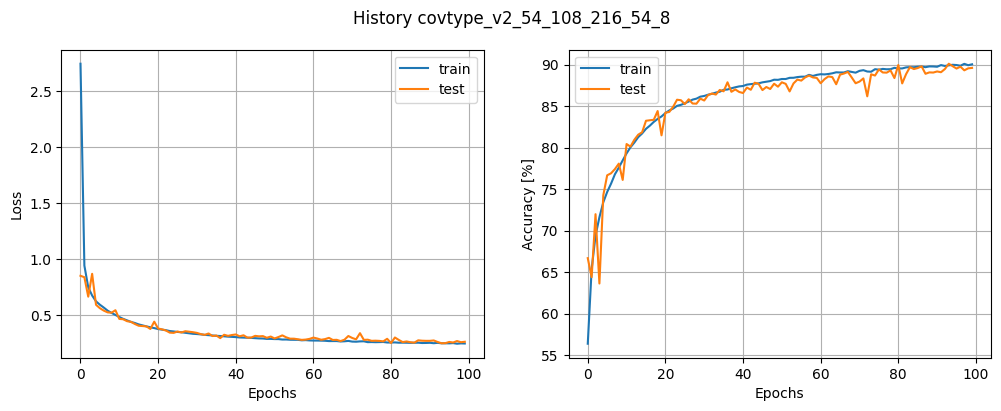

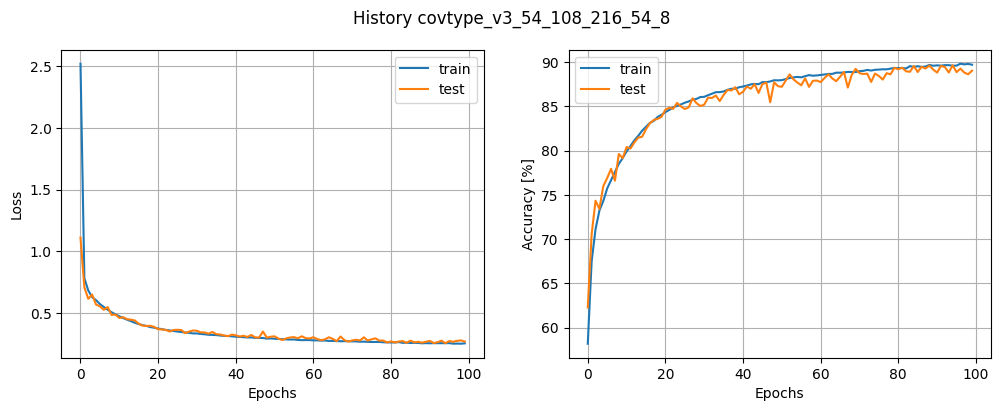

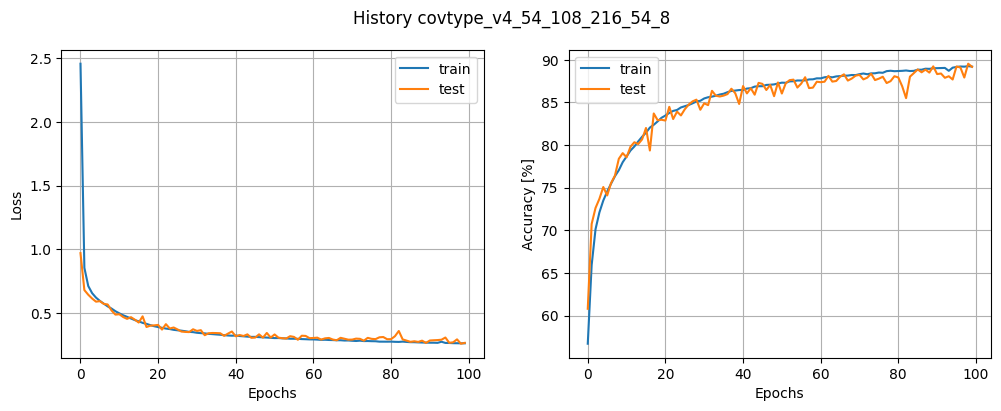

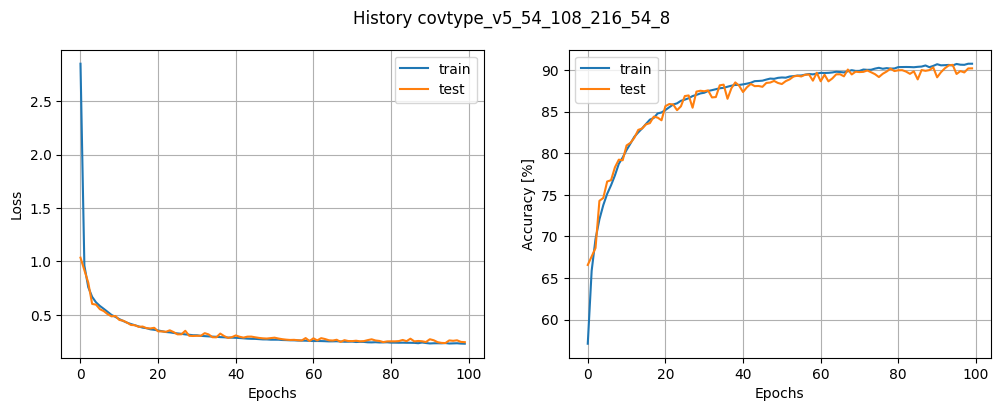

In [26]:
[plot_history(history, name)[0] for name, _, history in same_models_data]

In [34]:
# same_stacked_model = define_stacked_model(
#     [model_data[1] for model_data in same_models_data], [320, 150, 8]
# )
# same_stacked_history = stacked_fit(
#     same_stacked_model,
#     xtr,
#     ytr,
#     validation_data=(xts, yts),
#     epochs=100,
#     batch_size=256,
#     verbose=1,
# ).history
# model_save('stacked_same', same_stacked_model, same_stacked_history)
same_stacked_model, same_stacked_history = model_load("stacked_same")

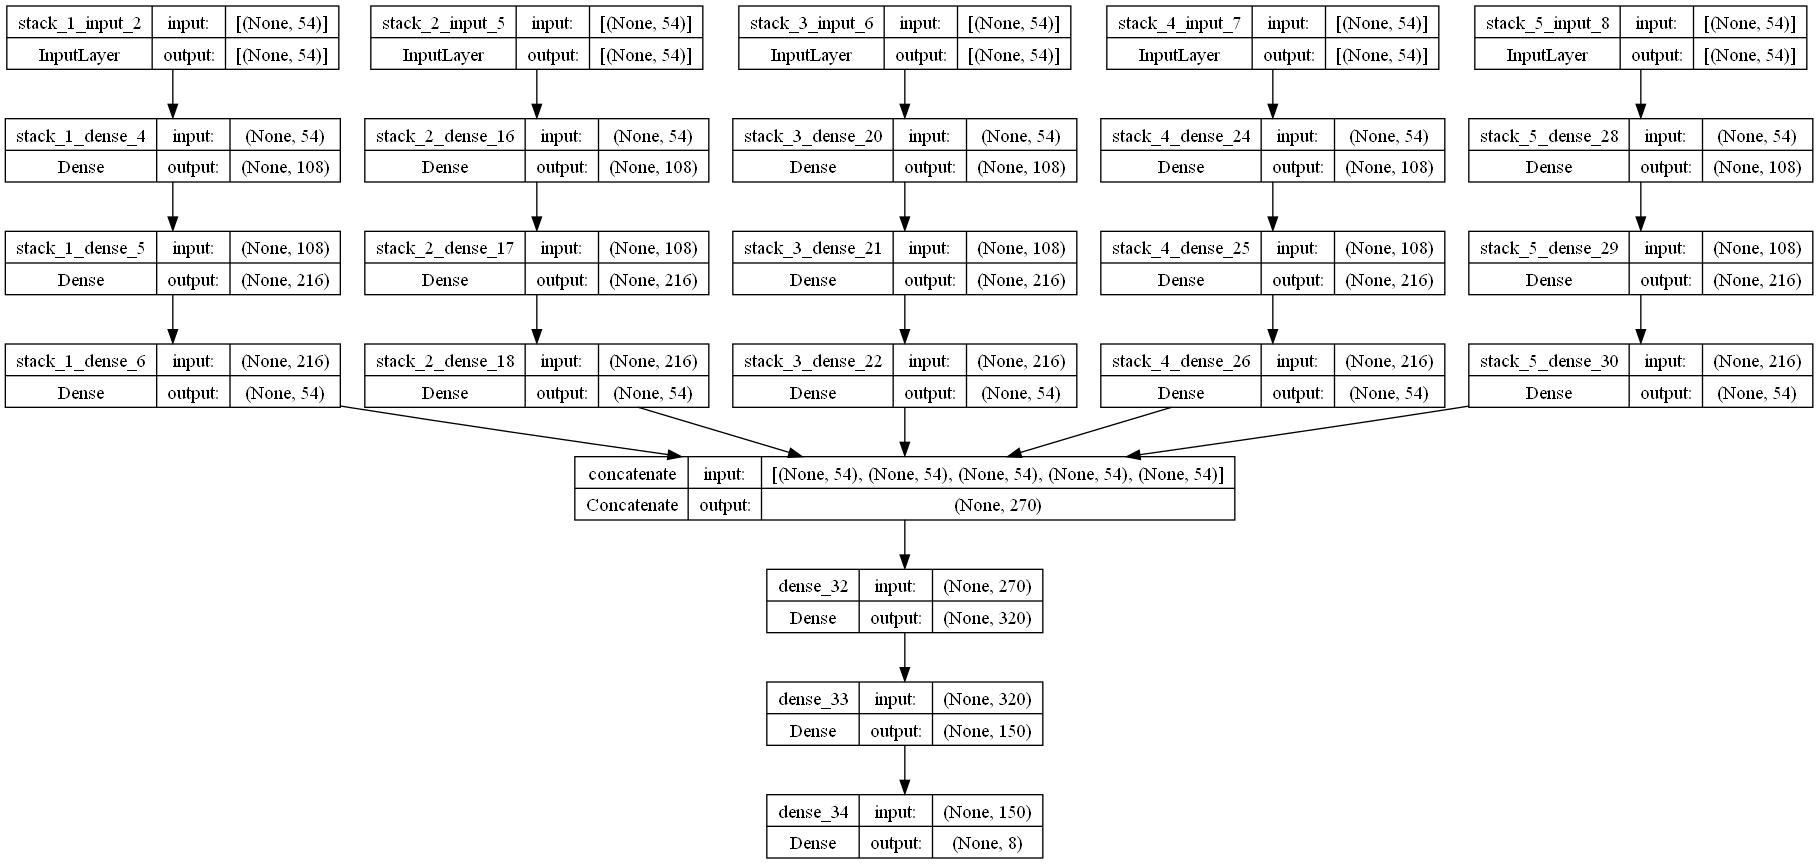

In [35]:
kutils.plot_model(same_stacked_model, show_shapes=True)

(<Figure size 1200x400 with 2 Axes>,
 (<Axes: xlabel='Epochs', ylabel='Loss'>,
  <Axes: xlabel='Epochs', ylabel='Accuracy [%]'>))

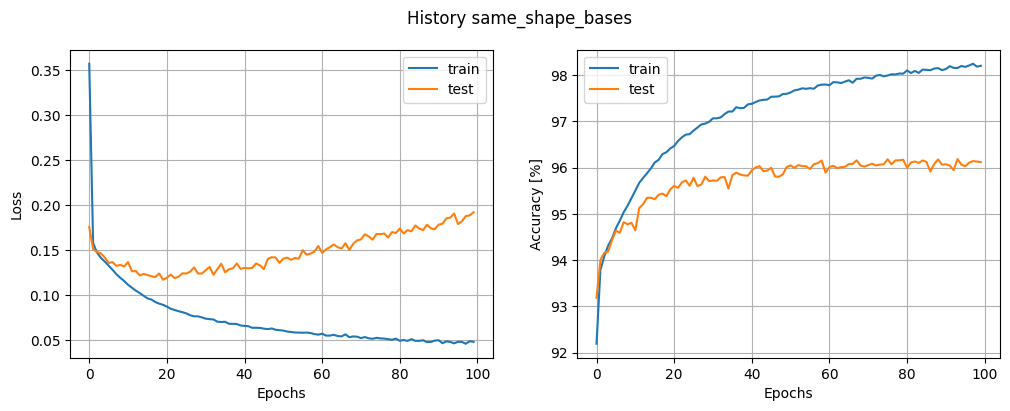

In [36]:
plot_history(same_stacked_history, "same_shape_bases")

In [37]:
stacked_evaluate(same_stacked_model, xts, yts, batch_size=256, verbose=0)

[0.19194801151752472, 0.9611886143684387]

In [60]:
# single_base_model = fit_multiple_dense(
#     [[54, 108, 216, 54, 8]],
#     xtr,
#     ytr,
#     validation_data=(xts, yts),
#     group_name="covtype_v1",
#     epochs=100,
#     batch_size=256,
#     verbose=0,
# )
# single_stacked_model = define_stacked_model(
#     [model_data[1] for model_data in single_base_model], [320, 150, 8]
# )
# single_stacked_history = single_stacked_model.fit(
#     xtr,
#     ytr,
#     validation_data=(xts, yts),
#     epochs=100,
#     batch_size=256,
#     verbose=1,
# ).history
# model_save('stacked_single', single_stacked_model, single_stacked_history)
single_stacked_model, single_stacked_history = model_load("stacked_single")

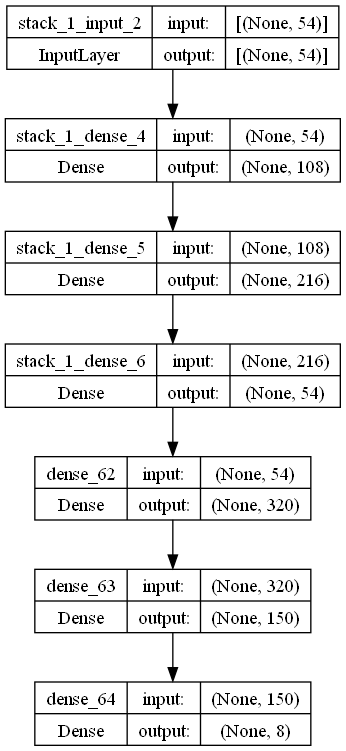

In [57]:
kutils.plot_model(single_stacked_model, show_shapes=True)

(<Figure size 1200x400 with 2 Axes>,
 (<Axes: xlabel='Epochs', ylabel='Loss'>,
  <Axes: xlabel='Epochs', ylabel='Accuracy [%]'>))

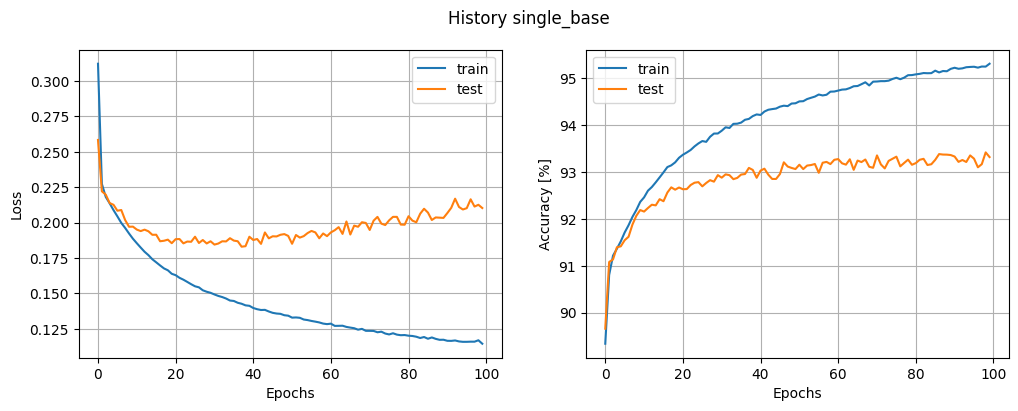

In [58]:
plot_history(single_stacked_history, "single_base")

In [59]:
single_stacked_model.evaluate(xts, yts, batch_size=256, verbose=0)

[0.2103365957736969, 0.9331945180892944]

### What to test
- Same shape subnets
- Check weight distribution
  - Are worse subnets used at all?
  - Can we read something from the weights?
- Train subnets with different types of data (one with soil types, one with light, one with slopes etc.)